In [ ]:
from utils.helper import preprocess_runs

path_name_dict = {
    'JOB-Light': 'JOB-light.json',
    'JOB': 'JOB.json',
    'JOB-Complex': 'JOB-Complex.json'
}
benchmark_stats_dict = preprocess_runs(json_path='workload_runs',path_name_dict=path_name_dict)

Loading run files from /PhD/ldb/ldb_data/runs/json
Benchmark: JOB-light (140 plans)


Cleaning SQL: 100%|██████████| 140/140 [00:01<00:00, 97.58it/s]


Benchmark: JOB (226 plans)


Cleaning SQL: 100%|██████████| 226/226 [00:02<00:00, 105.50it/s]


Benchmark: JOB-Complex (15805 plans)


Cleaning SQL: 100%|██████████| 15805/15805 [00:00<00:00, 65530.95it/s]


# extract info about the queries

In [2]:
import os
import json

def load_column_statistics(dataset, dataset_statistics_dir: str, scale_factor: str = None):
    if scale_factor is not None:
        col_stats_filename = f'column_statistics_scaled{scale_factor}.json'
    else:
        col_stats_filename = 'column_statistics.json'
    path = os.path.join(dataset_statistics_dir, dataset, col_stats_filename)
    assert os.path.exists(path), f"Could not find file ({path})"
    with open(path, 'r') as f:
        return json.load(f)


def get_table_rows_dict(dataset: str = 'imdb', dataset_scale_factor=1,
                        dataset_statistics_dir: str = 'dataset_info/', ):
    # load statistics for this dataset
    dataset_statistics = load_column_statistics(dataset=dataset, dataset_statistics_dir=dataset_statistics_dir,
                                                scale_factor=dataset_scale_factor)
    # construct table rows dict
    table_rows_dict = dict()
    for table in dataset_statistics.keys():
        for column in dataset_statistics[table].keys():
            if "num_rows" in dataset_statistics[table][column].keys():
                if table in table_rows_dict.keys():
                    assert table_rows_dict[table] == dataset_statistics[table][column][
                        "num_rows"], f"Table {table} has different row counts"
                table_rows_dict[table] = dataset_statistics[table][column]["num_rows"]
    return table_rows_dict


table_rows_dict = get_table_rows_dict()

In [3]:


# lookup pk/fk information
with open('dataset_info/imdb/schema.json', 'r') as f:
    schema = json.load(f)

table_col_info = schema['table_col_info']

pk_columns = []
fk_columns = []

# extract pk information
for table, columns in table_col_info.items():
    for column, info in columns.items():
        if info['pk']:
            pk_columns.append((table, column))

# extract fk information (from relationships)
relationships = schema['relationships']
for relationship in relationships:
    table1 = relationship[0]
    column1 = relationship[1]
    table2 = relationship[2]
    column2 = relationship[3]

    # check which side if pk
    is_pk1 = schema['table_col_info'][table1][column1]['pk']
    is_pk2 = schema['table_col_info'][table2][column2]['pk']

    if is_pk1 and not is_pk2:
        fk_columns.append((table2, column2))
    elif not is_pk1 and is_pk2:
        fk_columns.append((table1, column1))
    elif not is_pk1 and not is_pk2:
        # a transitive relationship very likely
        fk_columns.append((table1, column1))
        fk_columns.append((table2, column2))
    else:
        raise ValueError(
            f'Both sides are pk or neither side is pk: {table1}.{column1} <-> {table2}.{column2} (is_pk1={is_pk1}, is_pk2={is_pk2})')


In [4]:
from utils.parse_query import get_query_tables, get_preds_from_query, parse_join_conditions, \
    extract_filter_jon_conditions
import sqlparse
from typing import Dict
from collections import defaultdict


def compute_intermediate_cardinality(plan) -> int:
    # child cardinality
    card = 0
    if 'Plans' in plan.keys():
        for child in plan['Plans']:
            card += compute_intermediate_cardinality(child)

    # check if self is join
    op_name = plan['Node Type']
    if op_name in ['Hash Join', 'Merge Join', 'Nested Loop']:
        # get cardinality (actual)
        card += plan['Actual Rows']
    elif op_name in ['Seq Scan', 'Index Scan', 'Bitmap Heap Scan']:
        # get cardinality (actual)
        card += plan['Actual Rows']

    return card


def extract_query_stats(sql: str, plan_info: Dict) -> Dict[str, int]:
    # extract the following information:
    # - num tables > 1m rows
    # - sum of intermed cardinality
    # - runtime distribution
    # - num filters
    # - num strings in filter
    # - operator types in filters
    # - datatype in join condition

    # Extract query first
    parsed_query = sqlparse.parse(sql)
    assert len(parsed_query) == 1, "Multiple queries found per line"

    # Get distinct join tables from query
    tables, alias_table_dict = get_query_tables(parsed_query)
    tables = [t if t in table_rows_dict.keys() else t.lower() for t in tables]

    # extract base table sizes
    base_table_sizes = [table_rows_dict[t] for t in tables]

    # extract intermediate card
    pg_plan = plan_info['pg_plan']
    intermed_card = compute_intermediate_cardinality(pg_plan['Plan'])

    # extract predicates
    try:
        predicates, num_disjunctions = get_preds_from_query(parsed_query, flatten_disjunction=True)
    except Exception as e:
        print(sql, flush=True)
        raise e

    filter_conds, filter_operators, filter_cols, join_conds = extract_filter_jon_conditions(predicates)
    assert len(join_conds) >= len(tables) - 1, f'join_conds={join_conds}, tables={tables}'

    # extract dtypes for filter cols
    assert len(filter_conds) == len(filter_cols), f'filter_conds={filter_conds}, filter_cols={filter_cols}'
    filter_dtype_counters = defaultdict(int)
    for f in filter_cols:
        assert isinstance(f, str)
        t, c = f.split('.')

        # translate alias
        t = alias_table_dict[t]

        # lookup dtype
        dtype = table_col_info[t][c]['type']

        # cleanup dtype
        if dtype.startswith('varchar'):
            dtype = 'varchar'

        filter_dtype_counters[dtype] += 1

    # normalize with num filters
    for k in filter_dtype_counters.keys():
        filter_dtype_counters[k] = filter_dtype_counters[k] / len(filter_conds)

    # process join conditions
    join_conds = parse_join_conditions(join_conds, alias_table_dict=alias_table_dict)

    # extract pk/fk information about join conditions - percentage of join conditions on non-pk/fk columns
    num_join_conds_non_pk_fk = 0
    join_cond_dtype_counters = defaultdict(int)
    for jc in join_conds:

        assert isinstance(jc, tuple), f'jc={jc} is not a tuple {type(jc)}'
        assert len(jc) == 4
        t1, c1, t2, c2 = jc

        # check lowercase fixes
        if t1 not in table_col_info and t1.lower() in table_col_info:
            # make lower case
            t1 = t1.lower()
        if t2 not in table_col_info and t2.lower() in table_col_info:
            # make lower case
            t2 = t2.lower()

        assert t1 in table_col_info, f't1={t1} not in table_col_info: {table_col_info.keys()}'
        assert t2 in table_col_info, f't2={t2} not in table_col_info: {table_col_info.keys()}'
        assert c1 in table_col_info[t1], f'c1={c1} not in table_col_info[{t1}]: {table_col_info[t1].keys()}'
        assert c2 in table_col_info[t2], f'c2={c2} not in table_col_info[{t2}]: {table_col_info[t2].keys()}'

        left_key = (t1, c1)
        right_key = (t2, c2)

        if left_key not in pk_columns and left_key not in fk_columns and right_key not in fk_columns and right_key not in pk_columns:
            num_join_conds_non_pk_fk += 1

        # extract col datatype
        type1 = table_col_info[t1][c1]['type']
        type2 = table_col_info[t2][c2]['type']

        # rewrite varchar(5)
        if type1.startswith('varchar'):
            type1 = 'varchar'
        if type2.startswith('varchar'):
            type2 = 'varchar'

        # update datatype options
        join_cond_dtype_counters[type1] += 1
        join_cond_dtype_counters[type2] += 1

    # set join cond dtype counters relative to the number of join conditions
    for k in join_cond_dtype_counters.keys():
        join_cond_dtype_counters[k] = join_cond_dtype_counters[k] / len(
            join_conds) / 2  # divide by 2 because we have two columns in the join condition

    return {
        'num_tables': len(tables),
        'base_table_sizes': base_table_sizes,
        'intermed_card': intermed_card,
        'num_disjunctions': num_disjunctions,
        'num_filters': len(filter_conds),
        'filter_operators': filter_operators,
        'filter_col_dtypes': filter_dtype_counters,
        'non_pk_fk_join_ratio': num_join_conds_non_pk_fk / len(join_conds) if len(join_conds) > 0 else 0,
        'join_cond_dtypes': join_cond_dtype_counters,
        'opt_runtime': plan_info['opt_runtime'] / 1000,
        'pg_runtime': plan_info['pg_runtime'] / 1000 if plan_info['pg_runtime'] is not None else None,
    }


per_benchmark_stats_lists = dict()
for benchmark_name, info in benchmark_stats_dict.items():
    stats_list = []
    for sql, plan_info in info.items():
        stats = extract_query_stats(sql, plan_info)
        stats_list.append(stats)

    per_benchmark_stats_lists[benchmark_name] = stats_list

benchmark_names = list(per_benchmark_stats_lists.keys())

# Num Tables

In [ ]:
from typing import List, Dict
import matplotlib.pyplot as plt
import numpy as np

def plot_hist(benchmark_names: List[str], data: Dict[str, List[int]], x_axis: str, starts_with_zero: bool = False,
              make_relative: bool = False, external_ax=None, show_legend: bool = True, legend_placement=None,
              legend_num_cols: int = 1, num_bins: int = None, show_y_label: bool = True,
              cap_max_val=None):
    # Calculate bar positions
    bar_width = 1 / (len(benchmark_names) + .7)

    all_values = list(np.concatenate([data[benchmark_name] for benchmark_name in benchmark_names]))
    if starts_with_zero:
        all_values.append(0)
    else:
        all_values.append(1)

    if cap_max_val is not None:
        # cap the max value to cap_max_val
        all_values = [min(v, cap_max_val) for v in all_values]

    min_data = min(all_values)
    max_data = max(all_values)

    # assert max_data < 100, f'this does not scale otherwise!'

    if num_bins is None:
        x = np.arange(min_data, max_data + 1)
        bins = np.arange(min_data, max_data + 2)
    else:
        x = np.arange(num_bins)
        _, bins = np.histogram(all_values, bins=num_bins)

    offsets = np.arange(len(benchmark_names)) * bar_width

    # Plot the bars
    if external_ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    else:
        ax = external_ax

    for i, (benchmark, data_series) in enumerate(data.items()):
        counts, _ = np.histogram(data_series, bins=bins)
        if make_relative:
            # normalize counts by the total number of queries for this benchmark
            counts = counts / len(data_series)
        ax.bar(x + offsets[i], counts, width=bar_width, label=benchmark)

    ax.set_xlabel(x_axis)
    if show_y_label:
        ax.set_ylabel('Number of Queries' if not make_relative else 'Normalized Frequency')
    # ax.set_title('Distribution per Benchmark')
    # ax.xticks(x + bar_width * (len(benchmark_names) - 1) / 2, x)

    # add xtick labels
    if num_bins is None:
        ax.set_xticks(bins, [f'{int(b)}' for b in bins], rotation=45)
    else:
        ax.set_xticks(x + bar_width * (len(benchmark_names) - 1) / 2,
                      [f'{int(bins[i])}-{int(bins[i + 1])}' for i in range(len(x))])

    if show_legend:
        if legend_placement:
            ax.legend(bbox_to_anchor=legend_placement, ncol=legend_num_cols, frameon=False)
        else:
            ax.legend()

    ax.grid(True, color='lightgrey', linewidth=0.7, alpha=0.7)
    ax.set_axisbelow(True)

    if external_ax is None:
        fig.show()

C:\Users\Johannes\AppData\Local\Temp\ipykernel_31608\1138150217.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


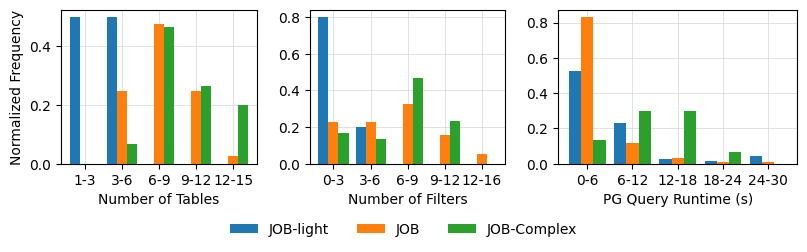

In [14]:
key_title_list = [
    ('num_tables', 'Number of Tables', False, True, None),
    ('num_filters', 'Number of Filters', True, True, None),
    # ('opt_runtime', 'Optimal Query Runtime', True, True, 12),
    ('pg_runtime', 'PG Query Runtime (s)', True, True, 30),
]

fig = plt.figure(figsize=(9.5, 2))
# gs = fig.add_gridspec(1, len(key_title_list)+1, width_ratios=[1]*len(key_title_list) + [0.8], wspace=0.4)
gs = fig.add_gridspec(1, len(key_title_list), width_ratios=[0.9, 0.9, 1.1], wspace=0.25)
axs = [fig.add_subplot(gs[0, i]) for i in range(len(key_title_list))]

for i in range(len(key_title_list)):
    key, title, start_with_zero, make_relative, cap_max = key_title_list[i]
    data = {benchmark: [stats[key] for stats in stats_list]
            for benchmark, stats_list in per_benchmark_stats_lists.items()}
    plot_hist(benchmark_names, data, title, starts_with_zero=start_with_zero, make_relative=make_relative,
              external_ax=axs[i], show_legend=i == 0, legend_placement=(2.7, -.3), legend_num_cols=3, num_bins=5,
              show_y_label=i == 0, cap_max_val=cap_max)

fig.show()
fig.savefig('tmp/num_tables_filters_histogram.pdf', bbox_inches='tight', dpi=300,
            transparent=False)

C:\Users\Johannes\AppData\Local\Temp\ipykernel_31608\4115289756.py:73: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\Johannes\AppData\Local\Temp\ipykernel_31608\4115289756.py:73: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


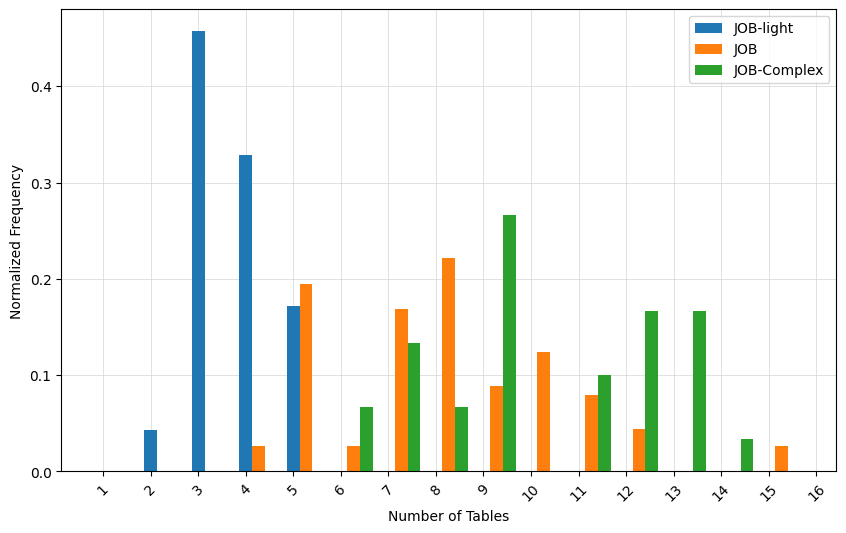

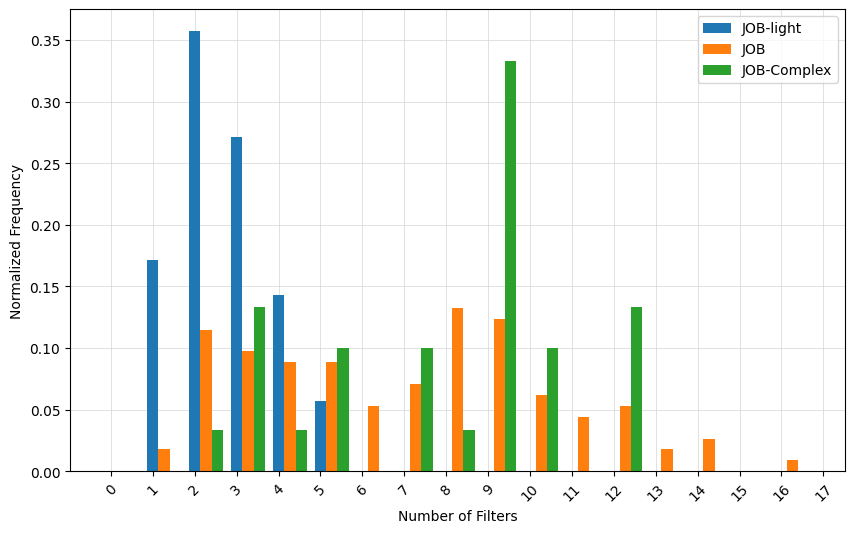

In [15]:
key_title_list = [
    ('num_tables', 'Number of Tables', False, True),
    ('num_filters', 'Number of Filters', True, True),
]

for key, title, start_with_zero, make_relative in key_title_list:
    data = {benchmark: [stats[key] for stats in stats_list]
            for benchmark, stats_list in per_benchmark_stats_lists.items()}
    plot_hist(benchmark_names, data, title, starts_with_zero=start_with_zero, make_relative=make_relative)

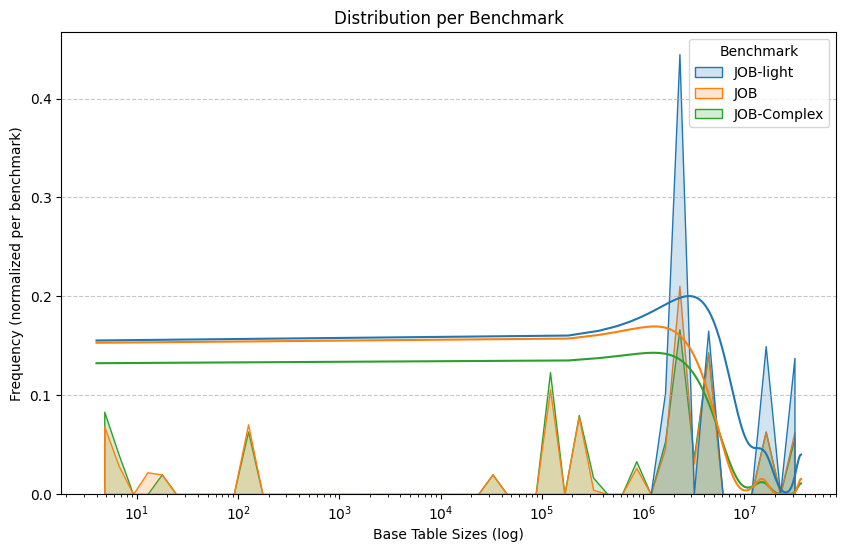

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Prepare data for the bar plot
benchmark_names = list(per_benchmark_stats_lists.keys())
base_table_sizes_data = dict()
for benchmark, stats_list in per_benchmark_stats_lists.items():
    sizes_lists = [stats['base_table_sizes'] for stats in stats_list]

    # convert to numpy array
    sizes_lists = [np.array(sizes_list) for sizes_list in sizes_lists]

    # flatten the list of lists
    sizes = np.concatenate(sizes_lists)

    base_table_sizes_data[benchmark] = sizes

import seaborn as sns
import pandas as pd


def plot_hist_sns(benchmark_names: List[str], data: Dict[str, List[int]], x_axis: str, logscale: bool = False,
                  kde: bool = False, common_norm: bool = False, element='bars'):
    # Prepare data for seaborn
    plot_data = []
    for benchmark, data_series in data.items():
        for value in data_series:
            plot_data.append({'Benchmark': benchmark, x_axis: value})

    # Convert to DataFrame
    df = pd.DataFrame(plot_data)

    # Plot using seaborn
    plt.close()
    plt.figure(figsize=(10, 6))

    if logscale:
        bins = np.logspace(np.log10(df[x_axis].min()), np.log10(df[x_axis].max()), 50)
    else:
        bins = 30
    sns.histplot(data=df, x=x_axis, hue='Benchmark', multiple='layer', bins=bins, kde=kde, shrink=0.8,
                 stat='probability', common_norm=common_norm, common_bins=True, element=element, alpha=0.2)
    # sns.kdeplot(data=df, x=x_axis, hue='Benchmark', multiple='layer', fill=True, common_norm=False)

    plt.xlabel(x_axis)
    plt.ylabel('Frequency (normalized per benchmark)')
    plt.title('Distribution per Benchmark')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    if logscale:
        plt.xscale('log')
    plt.show()


plot_hist_sns(benchmark_names, base_table_sizes_data, 'Base Table Sizes (log)', logscale=True, kde=True,
              common_norm=False, element='poly')

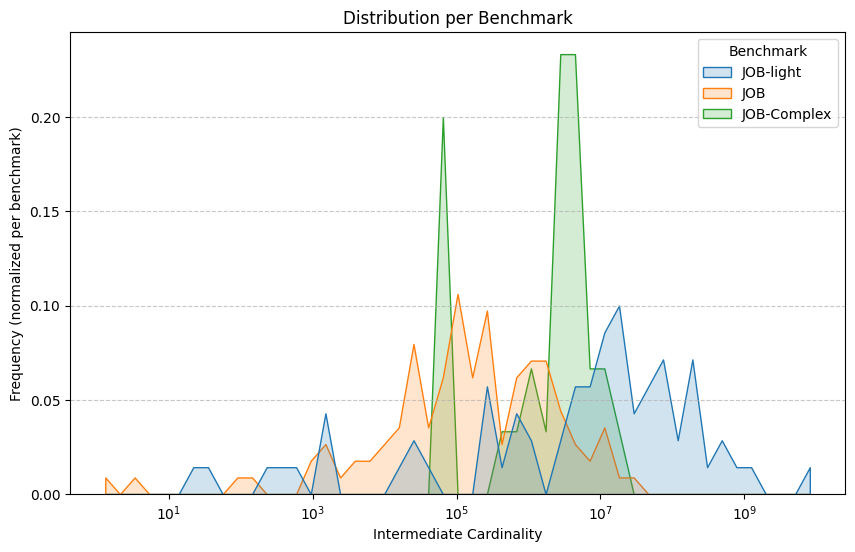

In [9]:
# Prepare data for the bar plot
benchmark_names = list(per_benchmark_stats_lists.keys())
intermed_card_data = {benchmark: [stats['intermed_card'] for stats in stats_list]
                      for benchmark, stats_list in per_benchmark_stats_lists.items()}
plot_hist_sns(benchmark_names, intermed_card_data, 'Intermediate Cardinality', logscale=True, kde=False,
              common_norm=False, element='poly')

# Non-PK / FK Join Ratio

In [10]:
import tabulate

# Prepare data for the bar plot
benchmark_names = list(per_benchmark_stats_lists.keys())
non_pk_fk_join_ratio_data = {benchmark: [stats['non_pk_fk_join_ratio'] for stats in stats_list]
                             for benchmark, stats_list in per_benchmark_stats_lists.items()}

tabulate_rows = [[''] + list(per_benchmark_stats_lists.keys())]

# extract non pk/fk information
non_pk_fk_row = []
for benchmark, stats_list in per_benchmark_stats_lists.items():
    max_val = np.max(non_pk_fk_join_ratio_data[benchmark])
    mean = np.mean(non_pk_fk_join_ratio_data[benchmark])
    median = np.median(non_pk_fk_join_ratio_data[benchmark])
    non_pk_fk_row.append(f'{mean:.2f} / {median:.2f}' if max_val > 0 else '-')
tabulate_rows.append(['Non-PK/FK Join Ratio'] + non_pk_fk_row)

# extract join cond dtypes
all_jc_dtypes = set()
for benchmark, stats_list in per_benchmark_stats_lists.items():
    for stats in stats_list:
        all_jc_dtypes.update(stats['join_cond_dtypes'].keys())

for dtype in all_jc_dtypes:
    row = []

    for benchmark, stats_list in per_benchmark_stats_lists.items():
        median = np.median([stats['join_cond_dtypes'].get(dtype, 0) for stats in stats_list])
        mean = np.mean([stats['join_cond_dtypes'].get(dtype, 0) for stats in stats_list])

        row.append(f'{mean:.2f} / {median:.2f}' if median > 0 else '-')

    tabulate_rows.append([f'JoinCond Ratio {dtype}'] + row)

# extract filter cond dtypes
all_filter_dtypes = set()
for benchmark, stats_list in per_benchmark_stats_lists.items():
    for stats in stats_list:
        all_filter_dtypes.update(stats['filter_col_dtypes'].keys())

for dtype in all_filter_dtypes:
    row = []

    for benchmark, stats_list in per_benchmark_stats_lists.items():
        median = np.median([stats['filter_col_dtypes'].get(dtype, 0) for stats in stats_list])
        mean = np.mean([stats['filter_col_dtypes'].get(dtype, 0) for stats in stats_list])

        row.append(f'{mean:.2f} / {median:.2f}' if median > 0 else '-')

    tabulate_rows.append([f'Filter Ratio {dtype}'] + row)

all_keys = ['<', '>', '<=', '>=', '=', '!=', 'LIKE', 'NOT LIKE', 'BETWEEN', 'IN', 'IS']
for filter_cmp in all_keys:
    row = []

    for benchmark, stats_list in per_benchmark_stats_lists.items():
        data = [stats['filter_operators'].get(filter_cmp, 0) for stats in stats_list]

        min_val = np.min(data)
        max_val = np.max(data)
        median = np.median(data)
        mean = np.mean(data)

        row.append(f'{min_val}-{max_val} ({mean:.2f} / {median:.2f})' if max_val > 0 else '-')

    tabulate_rows.append([f'Filter {filter_cmp}'] + row)

print(tabulate.tabulate(
    [[f'\033[1m{row[0]}\033[0m'] + row[1:] for row in tabulate_rows],  # Highlight first column
    tablefmt='fancy_grid'  # Example formatting option
))

╒════════════════════════╤═══════════════════╤════════════════════╤═══════════════════╕
│                        │ JOB-light         │ JOB                │ JOB-Complex       │
├────────────────────────┼───────────────────┼────────────────────┼───────────────────┤
│ Non-PK/FK Join Ratio   │ -                 │ -                  │ 0.13 / 0.10       │
├────────────────────────┼───────────────────┼────────────────────┼───────────────────┤
│ JoinCond Ratio varchar │ -                 │ -                  │ 0.13 / 0.10       │
├────────────────────────┼───────────────────┼────────────────────┼───────────────────┤
│ JoinCond Ratio integer │ 1.00 / 1.00       │ 1.00 / 1.00        │ 0.87 / 0.90       │
├────────────────────────┼───────────────────┼────────────────────┼───────────────────┤
│ Filter Ratio varchar   │ -                 │ 0.88 / 0.89        │ 0.90 / 0.89       │
├────────────────────────┼───────────────────┼────────────────────┼───────────────────┤
│ Filter Ratio integer   │ 1.00 